<a href="https://colab.research.google.com/github/HectorCedilloCharles1/MineriaDeDatos/blob/main/Ejercicio_de_t%C3%A9cnicas_de_m%C3%ADneria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio de técnicas de minería**



---


#Equipo: 5
#Grupo: 001 Frecuencia: Lunes 7-10pm
#Integrantes:
* 1844452 - Castillo Rodríguez, Leonardo Daniel
* 1851642 - Cedillo Charles, Hector
* 1877422 - Martinez Ortuño, Gustavo Juan
* 1851701 - Navarrete Rosales, Jose Eduardo
* 1869864 - Morales Salazar, César Alejandro


#Técnica de minería a utilizar: Kmedias
La técnica de Kmedias nos será útil ya que, si bien buscamos identificar a los mejores jugadores del mundo, para así analizar sus cualidades, en nuestra base de datos que hemos trabajado no se nos agrupan por posiciones, es decir, probablemente los jugadores con mayor media serán los delanteros, cosa que sesgaría nuestro análisis.

Al aplicar la técnica agruparemos a los jugadores en 4 posiciones:

*   Porteros
*   Defensas
*   Centrocampistas
*   Delanteros
 
 Y es posible ya que cada posición cuenta con características similares. Con esto podremos terminar nuestro objetivo que era encontrar las características de los mejores jugadores según la posición.

# 1. Ejemplo de K-medias en kaggle.com 

El ejemplo que se muestra a continuación se obtuvo del siguiente link:  
[Ejemplo K-medias](https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering)

## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
We aim to segement the Customers based on RFM so that the company can target its customers efficiently.

#### The steps are broadly divided into:

1. [Step 1: Reading and Understanding the Data](#1)
1. [Step 2: Data Cleansing](#2)
1. [Step 3: Data Preparation](#3)
1. [Step 4: Model Building](#4)
1. [Step 5: Final Analysis](#5)

<a id="1"></a> <br>
## Step 1 : Reading and Understanding Data

In [ ]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
# Reading the data on which analysis needs to be done

retail = pd.read_csv('/content/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
# shape of df

retail.shape

(541909, 8)

<a id="2"></a> <br>
## Step 2 : Data Cleansing

In [ ]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [ ]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [ ]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [ ]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d/%m/%Y %H:%M')

In [ ]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [ ]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [ ]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [ ]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

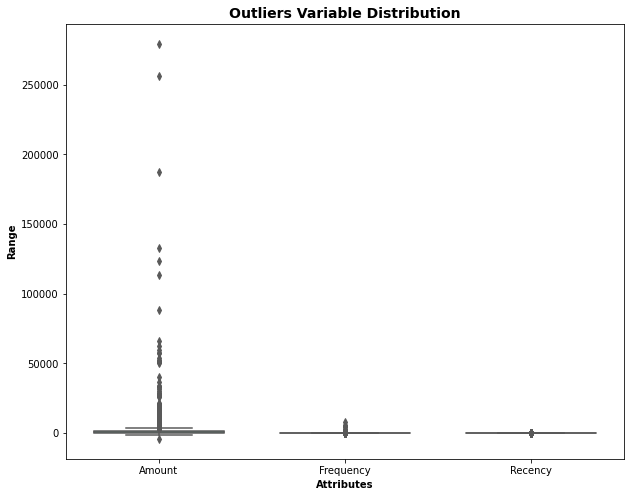

In [ ]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

In [ ]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


<a id="4"></a> <br>
## Step 4 : Building the Model

### K-Means Clustering  
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [ ]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 2], dtype=int32)

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

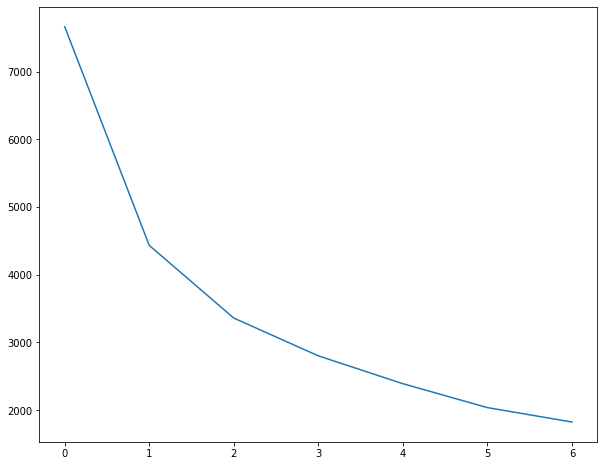

In [ ]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [ ]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.477782010021685
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.41742250872395564
For n_clusters=7, the silhouette score is 0.4150058806779277
For n_clusters=8, the silhouette score is 0.40287248830182115


In [ ]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

In [ ]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<a id="5"></a> <br>
## Step 5 : Final Analysis

### Inference:
K-Means Clustering with 3 Cluster Ids
- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

Hierarchical Clustering with 3 Cluster Labels
- Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster_Labels 2 are frequent buyers.
- Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.

</a> <br>
# 2. Técnica de K-medias aplicada a nuestra base de datos

Debido a que como se mencionó al inicio, la idea es agruparlos en 4 grupos, ya esta definido el número de clusters, por lo que utilizaremos el código a partir del 4 ejemplo obtenido de kaggle.

In [ ]:
#Importamos las librerías
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [ ]:
#Partimos de nuestra base de datos con los registros totales por jugador
Base_Jugadores_Unicos=pd.read_table('/content/Base Estadisticas de Jugadores.csv', sep=',')
del(Base_Jugadores_Unicos['Unnamed: 0'])
Base_Jugadores_Unicos

,ID,Goles Promedio,Calificacion Promedio,Win rate,Estatura,Cruce,Finalizacion,Cabeceo,PaseCorto,Voleas,Dribbling,Efecto,Precision,PaseLargo,Control,Aceleracion,Velocidad,Agilidad,Reaccion,Balance,FuerzaTiro,Salto,Resistencia,Fuerza,TiroLargo,Agresividad,Intercepcion,Posicionamiento,Vision,Penales,Marcaje,Entrada,Barridas,POR_EST,POR_PA,POR_DES,POR_POS,POR_REF,Goles,Faltas,1raAmarilla,2daAmarilla,Edad Minima,Edad Maxima,Nombre,Pie
0,30726,0.000000,83.632184,1.574713,198.0,17.793103,16.103448,17.057471,27.000000,12.000000,17.229885,12.000000,11.000000,63.666667,22.000000,38.620690,41.000000,57.000000,68.000000,51.000000,29.000000,60.000000,56.551724,73.057471,16.494253,57.000000,60.517241,43.229885,40.000000,42.459770,17.057471,20.310345,11.000000,83.413793,85.931034,85.000000,91.149425,78.356322,0,0,2,0,38,41,Edwin van der Sar,right
1,30362,0.049505,76.073267,1.544554,185.0,59.455446,22.089109,73.762376,64.237624,31.039604,52.752475,44.752475,24.039604,56.821782,63.910891,61.891089,64.831683,48.772277,66.306931,63.683168,43.039604,79.752475,62.217822,79.633663,23.099010,79.485149,79.039604,53.653465,52.405941,45.247525,78.712871,78.544554,76.871287,12.930693,13.782178,21.376238,10.415842,12.940594,5,97,14,0,29,37,Wes Brown,right
2,30620,0.007519,84.295614,1.353383,193.0,45.000000,39.000000,85.451128,74.631579,51.000000,58.225564,51.000000,27.000000,72.406015,69.541353,63.879699,68.112782,53.233083,80.390977,56.473684,59.000000,71.150376,60.962406,83.458647,29.000000,81.714286,83.729323,47.263158,60.691729,64.751880,85.849624,90.187970,85.714286,12.661654,12.691729,24.135338,12.691729,9.849624,1,41,11,0,30,37,Rio Ferdinand,right
3,30865,0.080247,86.548560,1.462963,190.0,38.987654,37.129630,90.895062,68.888889,39.987654,46.024691,42.790123,45.753086,62.370370,64.530864,63.049383,66.098765,51.067901,76.962963,66.685185,58.864198,89.783951,70.191358,91.518519,31.666667,91.166667,83.197531,51.037037,58.259259,64.907407,87.728395,90.740741,84.135802,11.043210,11.512346,32.555556,13.302469,12.049383,13,183,34,4,27,34,Nemanja Vidic,right
4,32569,0.040323,82.823925,1.370968,175.0,78.516129,43.766129,72.931452,80.056452,52.802419,78.588710,73.120968,50.802419,74.056452,77.818548,83.552419,82.995968,80.850806,83.399194,78.983871,73.951613,86.919355,85.899194,74.258065,46.354839,83.963710,80.838710,70.241935,67.028226,61.895161,80.439516,84.161290,88.350806,11.850806,14.008065,24.653226,13.580645,9.463710,10,248,32,1,27,35,Patrice Evra,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,498033,0.121212,74.015152,NaN,177.0,74.212121,62.818182,46.606061,78.818182,54.030303,76.212121,77.121212,69.303030,73.212121,81.030303,69.000000,63.606061,69.000000,71.818182,75.000000,54.393939,54.000000,65.212121,56.606061,64.242424,44.606061,37.454545,66.606061,78.242424,55.606061,29.606061,41.030303,38.606061,12.606061,8.606061,5.606061,11.606061,9.606061,4,38,3,0,19,20,Marco Asensio,left
5034,484906,0.192308,68.623077,NaN,167.0,59.692308,66.846154,27.692308,76.692308,54.384615,73.076923,65.692308,59.615385,65.076923,69.692308,72.692308,67.384615,73.000000,54.076923,81.230769,58.384615,57.000000,64.615385,41.846154,61.692308,25.076923,15.307692,70.692308,61.461538,63.692308,17.307692,20.000000,15.307692,6.692308,10.692308,6.692308,7.692308,13.692308,5,24,2,0,25,26,Tana,right
5035,535600,0.037037,74.098765,NaN,180.0,62.185185,52.592593,57.000000,76.592593,45.592593,76.000000,55.000000,45.592593,69.185185,78.185185,75.185185,73.370370,69.185185,78.000000,70.185185,78.000000,61.000000,83.000000,67.000000,60.185185,85.000000,73.370370,66.000000,69.185185,58.000000,72.925926,76.185185,75.370370,16.000000,13.000000,9.000000,10.000000,14.000000,1,53,8,1,26,27,Petros,right
5036,495841,0.238095,68.142857,NaN,182.0,42.857143,72.428571,68.714286,59.428571,51.714286,69.285714,45.000000,43.000000,45.142857,68.285714,75.00

In [ ]:
#Eliminamos las columnas que no son sobre las cualidades de los jugadores
base=Base_Jugadores_Unicos
del(base['ID'])
del(base['Nombre'])
del(base['Pie'])
del(base['Goles'])
del(base['Win rate'])
del(base['1raAmarilla'])
del(base['2daAmarilla'])
del(base['Faltas'])
del(base['Goles Promedio'])
del(base['Calificacion Promedio'])
del(base['Edad Minima'])
del(base['Edad Maxima'])
base

,Estatura,Cruce,Finalizacion,Cabeceo,PaseCorto,Voleas,Dribbling,Efecto,Precision,PaseLargo,Control,Aceleracion,Velocidad,Agilidad,Reaccion,Balance,FuerzaTiro,Salto,Resistencia,Fuerza,TiroLargo,Agresividad,Intercepcion,Posicionamiento,Vision,Penales,Marcaje,Entrada,Barridas,POR_EST,POR_PA,POR_DES,POR_POS,POR_REF
0,198.0,17.793103,16.103448,17.057471,27.000000,12.000000,17.229885,12.000000,11.000000,63.666667,22.000000,38.620690,41.000000,57.000000,68.000000,51.000000,29.000000,60.000000,56.551724,73.057471,16.494253,57.000000,60.517241,43.229885,40.000000,42.459770,17.057471,20.310345,11.000000,83.413793,85.931034,85.000000,91.149425,78.356322
1,185.0,59.455446,22.089109,73.762376,64.237624,31.039604,52.752475,44.752475,24.039604,56.821782,63.910891,61.891089,64.831683,48.772277,66.306931,63.683168,43.039604,79.752475,62.217822,79.633663,23.099010,79.485149,79.039604,53.653465,52.405941,45.247525,78.712871,78.544554,76.871287,12.930693,13.782178,21.376238,10.415842,12.940594
2,193.0,45.000000,39.000000,85.451128,74.631579,51.000000,58.225564,51.000000,27.000000,72.406015,69.541353,63.879699,68.112782,53.233083,80.390977,56.473684,59.000000,71.150376,60.962406,83.458647,29.000000,81.714286,83.729323,47.263158,60.691729,64.751880,85.849624,90.187970,85.714286,12.661654,12.691729,24.135338,12.691729,9.849624
3,190.0,38.987654,37.129630,90.895062,68.888889,39.987654,46.024691,42.790123,45.753086,62.370370,64.530864,63.049383,66.098765,51.067901,76.962963,66.685185,58.864198,89.783951,70.191358,91.518519,31.666667,91.166667,83.197531,51.037037,58.259259,64.907407,87.728395,90.740741,84.135802,11.043210,11.512346,32.555556,13.302469,12.049383
4,175.0,78.516129,43.766129,72.931452,80.056452,52.802419,78.588710,73.120968,50.802419,74.056452,77.818548,83.552419,82.995968,80.850806,83.399194,78.983871,73.951613,86.919355,85.899194,74.258065,46.354839,83.963710,80.838710,70.241935,67.028226,61.895161,80.439516,84.161290,88.350806,11.850806,14.008065,24.653226,13.580645,9.463710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,177.0,74.212121,62.818182,46.606061,78.818182,54.030303,76.212121,77.121212,69.303030,73.212121,81.030303,69.000000,63.606061,69.000000,71.818182,75.000000,54.393939,54.000000,65.212121,56.606061,64.242424,44.606061,37.454545,66.606061,78.242424,55.606061,29.606061,41.030303,38.606061,12.606061,8.606061,5.606061,11.606061,9.606061
5034,167.0,59.692308,66.846154,27.692308,76.692308,54.384615,73.076923,65.692308,59.615385,65.076923,69.692308,72.692308,67.384615,73.000000,54.076923,81.230769,58.384615,57.000000,64.615385,41.846154,61.692308,25.076923,15.307692,70.692308,61.461538,63.692308,17.307692,20.000000,15.307692,6.692308,10.692308,6.692308,7.692308,13.692308
5035,180.0,62.185185,52.592593,57.000000,76.592593,45.592593,76.000000,55.000000,45.592593,69.185185,78.185185,75.185185,73.370370,69.185185,78.000000,70.185185,78.000000,61.000000,83.000000,67.000000,60.185185,85.000000,73.370370,66.000000,69.185185,58.000000,72.925926,76.185185,75.370370,16.000000,13.000000,9.000000,10.000000,14.000000
5036,182.0,42.857143,72.428571,68.714286,59.428571,51.714286,69.285714,45.000000,43.000000,45.142857,68.285714,75.000000,74.000000,57.571429,65.714286,60.000000,67.571429,61.000000,61.857143,62.000000,64.428571,35.000000,19.142857,64.000000,59.000000,77.000000,20.000000,20.000000,21.000000,6.000000,14.000000,13.000000,8.000000,6.000000


In [ ]:
#Aquellos registros faltantes seran llenados con 0
base=base.fillna(0)

In [ ]:
#Normalizacion de los datos
basenorm=(base-base.min())/(base.max()-base.min())
basenorm

,Estatura,Cruce,Finalizacion,Cabeceo,PaseCorto,Voleas,Dribbling,Efecto,Precision,PaseLargo,Control,Aceleracion,Velocidad,Agilidad,Reaccion,Balance,FuerzaTiro,Salto,Resistencia,Fuerza,TiroLargo,Agresividad,Intercepcion,Posicionamiento,Vision,Penales,Marcaje,Entrada,Barridas,POR_EST,POR_PA,POR_DES,POR_POS,POR_REF
0,0.883721,0.193248,0.174286,0.183917,0.282464,0.132074,0.178414,0.130225,0.117299,0.672433,0.229556,0.403776,0.429268,0.601803,0.733060,0.541253,0.308336,0.637373,0.604831,0.778761,0.181642,0.603348,0.639717,0.450311,0.416942,0.460109,0.188828,0.223828,0.116848,0.921743,0.999198,0.957866,1.000000,0.853579
1,0.581395,0.645735,0.239069,0.795321,0.672031,0.341627,0.546246,0.485658,0.256346,0.600139,0.666871,0.647066,0.678784,0.514935,0.714808,0.675857,0.457609,0.847202,0.665431,0.848860,0.254377,0.841354,0.835514,0.558890,0.546256,0.490318,0.871360,0.865593,0.816567,0.142887,0.160258,0.240889,0.114272,0.140969
2,0.767442,0.488737,0.422094,0.921351,0.780769,0.561315,0.602920,0.553457,0.287915,0.764736,0.725621,0.667856,0.713137,0.562032,0.866638,0.599344,0.627305,0.755822,0.652004,0.889632,0.319361,0.864950,0.885088,0.492325,0.632624,0.701674,0.950365,0.993908,0.910502,0.139914,0.147578,0.271981,0.139241,0.107297
3,0.697674,0.423438,0.401851,0.980049,0.720691,0.440111,0.476581,0.464362,0.487888,0.658742,0.673340,0.659176,0.692051,0.539172,0.829683,0.707717,0.625861,0.953765,0.750710,0.975547,0.348728,0.965004,0.879466,0.531636,0.607269,0.703359,0.971163,1.000000,0.893734,0.122030,0.133864,0.366869,0.145941,0.131261
4,0.348837,0.852750,0.473677,0.786361,0.837522,0.581153,0.813778,0.793515,0.541732,0.782167,0.811989,0.873533,0.868964,0.853618,0.899067,0.838240,0.786274,0.923335,0.918708,0.791558,0.510481,0.888760,0.854532,0.731687,0.698673,0.670717,0.890474,0.927492,0.938508,0.130954,0.162884,0.277817,0.148993,0.103093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,0.395349,0.806005,0.679876,0.502516,0.824567,0.594667,0.789168,0.836926,0.739013,0.773250,0.845501,0.721389,0.665952,0.728498,0.774221,0.795960,0.578332,0.573636,0.697456,0.603396,0.707467,0.472157,0.395925,0.693813,0.815565,0.602566,0.327742,0.452171,0.410094,0.139300,0.100070,0.063175,0.127330,0.104644
5034,0.162791,0.648307,0.723471,0.298584,0.802327,0.598566,0.756704,0.712899,0.635709,0.687328,0.727196,0.759991,0.705513,0.770730,0.582965,0.862086,0.620762,0.605505,0.691074,0.446062,0.679384,0.265440,0.161815,0.736378,0.640648,0.690192,0.191598,0.220408,0.162606,0.073952,0.124329,0.075416,0.084392,0.149158
5035,0.465116,0.675382,0.569206,0.614585,0.801284,0.501800,0.786972,0.596865,0.486177,0.730718,0.815814,0.786054,0.768184,0.730453,0.840862,0.744862,0.829318,0.647996,0.887701,0.714191,0.662787,0.899729,0.775585,0.687500,0.721156,0.628508,0.807298,0.839592,0.800623,0.176804,0.151163,0.101421,0.109710,0.152510
5036,0.511628,0.465464,0.783889,0.740891,0.621720,0.569176,0.717446,0.488344,0.458531,0.476789,0.712519,0.784118,0.774776,0.607836,0.708419,0.636768,0.718438,0.647996,0.661574,0.660893,0.709517,0.370477,0.202356,0.666667,0.614990,0.834398,0.221402,0.220408,0.223073,0.066302,0.162791,0.146497,0.087768,0.065361


In [ ]:
#Echamos un vistazo a los datos
basenorm.describe()

,Estatura,Cruce,Finalizacion,Cabeceo,PaseCorto,Voleas,Dribbling,Efecto,Precision,PaseLargo,Control,Agilidad,Reaccion,Balance,FuerzaTiro,Salto,Resistencia,Fuerza,TiroLargo,Agresividad,Intercepcion,Posicionamiento,Vision,Penales,Marcaje,Entrada,Barridas,POR_EST,POR_PA,POR_DES,POR_POS,POR_REF
count,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000
mean,0.496543,0.625706,0.545920,0.646660,0.682934,0.544136,0.626624,0.580389,0.538106,0.636193,0.685965,0.688900,0.749949,0.690836,0.676184,0.715267,0.744838,0.742612,0.605992,0.686608,0.603020,0.608042,0.623600,0.620223,0.562736,0.599367,0.541548,0.165872,0.201810,0.285952,0.191081,0.192794
std,0.146852,0.186302,0.208897,0.176957,0.143154,0.215759,0.185499,0.212288,0.191700,0.135251,0.155836,0.156686,0.072509,0.149537,0.165661,0.138708,0.117712,0.109020,0.201530,0.152324,0.189980,0.182438,0.166749,0.156475,0.241360,0.240274,0.243843,0.199430,0.194199,0.222659,0.185845,0.196656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.395349,0.532180,0.378802,0.578272,0.644009,0.385216,0.541964,0.455788,0.405213,0.566333,0.649390,0.620473,0.706314,0.637546,0.607849,0.668270,0.700353,0.682212,0.480454,0.608508,0.456988,0.514637,0.549267,0.521879,0.303120,0.357264,0.297068,0.084606,0.114249,0.121513,0.105889,0.103489
50%,0.511628,0.675937,0.570500,0.679703,0.712181,0.583327,0.680605,0.627531,0.555724,0.657393,0.724320,0.712786,0.754167,0.718946,0.720058,0.735103,0.761774,0.753437,0.662654,0.725322,0.672889,0.659552,0.656150,0.640899,0.655117,0.709533,0.647974,0.110503,0.151163,0.195322,0.142623,0.141616
75%,0.581395,0.758937,0.720301,0.765329,0.770536,0.715401,0.755907,0.737886,0.688181,0.730965,0.779437,0.789587,0.797201,0.778236,0.789189,0.792410,0.818002,0.815737,0.756096,0.792847,0.748748,0.739242,0.738283,0.738063,0.771032,0.800654,0.750355,0.140135,0.186757,0.383233,0.177321,0.175874
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#Entrenamos al algoritmo y lo aplicamos en nuestra base de datos normalizados
#El numero de clusters son 4, ya que buscamos agruparlos en las 4 posiciones ya mencionadas
clustering=KMeans(n_clusters=4,max_iter=2500)
clustering.fit(basenorm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=2500,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
#Añadimos la columna a nuestra base original
Base_Jugadores_Unicos["KMedias"]=clustering.labels_

El algoritmo los agrupó de la siguiente manera:

*   0-Defensa
*   1-Centrocampista
*   2-Portero
*   3-Delantero

**La columna se encuentra al final de la tabla.**

Y con esto, tenemos el objetivo de nuestro trabajo casi completado, solo restaría aplicar una condicional para hallar a los mejores 5 jugadores de cada grupo para cer sus características, y así, concluir nuestro análisis.




In [ ]:
Base_Jugadores_Unicos.to_csv("Base Final.csv")

In [ ]:
Base_Jugadores_Unicos.head(15)

,Estatura,Cruce,Finalizacion,Cabeceo,PaseCorto,Voleas,Dribbling,Efecto,Precision,PaseLargo,Control,Aceleracion,Velocidad,Agilidad,Reaccion,Balance,FuerzaTiro,Salto,Resistencia,Fuerza,TiroLargo,Agresividad,Intercepcion,Posicionamiento,Vision,Penales,Marcaje,Entrada,Barridas,POR_EST,POR_PA,POR_DES,POR_POS,POR_REF,KMedias
0,198.0,17.793103,16.103448,17.057471,27.000000,12.000000,17.229885,12.000000,11.000000,63.666667,22.000000,38.620690,41.000000,57.000000,68.000000,51.000000,29.000000,60.000000,56.551724,73.057471,16.494253,57.000000,60.517241,43.229885,40.000000,42.459770,17.057471,20.310345,11.000000,83.413793,85.931034,85.000000,91.149425,78.356322,2
1,185.0,59.455446,22.089109,73.762376,64.237624,31.039604,52.752475,44.752475,24.039604,56.821782,63.910891,61.891089,64.831683,48.772277,66.306931,63.683168,43.039604,79.752475,62.217822,79.633663,23.099010,79.485149,79.039604,53.653465,52.405941,45.247525,78.712871,78.544554,76.871287,12.930693,13.782178,21.376238,10.415842,12.940594,0
2,193.0,45.000000,39.000000,85.451128,74.631579,51.000000,58.225564,51.000000,27.000000,72.406015,69.541353,63.879699,68.112782,53.233083,80.390977,56.473684,59.000000,71.150376,60.962406,83.458647,29.000000,81.714286,83.729323,47.263158,60.691729,64.751880,85.849624,90.187970,85.714286,12.661654,12.691729,24.135338,12.691729,9.849624,0
3,190.0,38.987654,37.129630,90.895062,68.888889,39.987654,46.024691,42.790123,45.753086,62.370370,64.530864,63.049383,66.098765,51.067901,76.962963,66.685185,58.864198,89.783951,70.191358,91.518519,31.666667,91.166667,83.197531,51.037037,58.259259,64.907407,87.728395,90.740741,84.135802,11.043210,11.512346,32.555556,13.302469,12.049383,0
4,175.0,78.516129,43.766129,72.931452,80.056452,52.802419,78.588710,73.120968,50.802419,74.056452,77.818548,83.552419,82.995968,80.850806,83.399194,78.983871,73.951613,86.919355,85.899194,74.258065,46.354839,83.963710,80.838710,70.241935,67.028226,61.895161,80.439516,84.161290,88.350806,11.850806,14.008065,24.653226,13.580645,9.463710,1
5,182.0,76.294118,65.712418,81.542484,83.718954,61.568627,68.424837,61.568627,46.124183,79.830065,77.928105,67.692810,65.856209,61.444444,80.457516,67.444444,72.758170,77.071895,85.588235,72.601307,73.111111,85.686275,82.692810,70.575163,74.954248,66.300654,82.307190,80.385621,77.124183,9.124183,17.503268,31.901961,13.620915,13.065359,1
6,187.0,76.097938,62.618557,72.706186,86.458763,67.000000,72.474227,64.000000,74.871134,86.185567,81.515464,60.597938,66.257732,58.000000,80.448454,68.046392,79.257732,72.000000,79.350515,71.989691,77.293814,70.515464,86.041237,72.340206,81.695876,78.824742,75.195876,77.628866,74.664948,12.237113,13.716495,25.876289,16.144330,11.288660,1
7,170.0,81.811594,65.956522,73.521739,90.318841,85.000000,75.000000,74.000000,67.000000,90.608696,87.869565,61.231884,61.492754,70.985507,81.521739,82.000000,87.231884,64.000000,58.869565,72.159420,83.927536,87.420290,86.202899,88.710145,92.971014,85.565217,58.768116,52.782609,36.000000,10.086957,16.463768,49.507246,18.086957,14.521739,1
8,177.0,88.255814,75.976744,64.162791,84.872093,80.790698,83.465116,87.000000,81.953488,81.174419,87.151163,74.523256,70.953488,79.372093,73.790698,71.976744,75.174419,61.348837,61.151163,63.337209,74.790698,59.930233,65.779070,85.360465,87.941860,86.197674,26.697674,45.965116,45.348837,10.000000,11.418605,36.860465,11.418605,11.418605,3
9,172.0,64.875000,73.912500,64.987500,62.262500,73.325000,71.750000,42.062500,57.162500,38.162500,69.837500,87.012500,84.375000,77.462500,71.350000,72.700000,72.112500,67.725000,68.525000,67.087500,60.050000,64.737500,25.462500,71.475000,60.062500,64.712500,32.975000,33.837500,29.150000,10.462500,15.662500,12.562500,10.862500,16.362500,3


#3 Métrica de evaluación

Fuente: https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam

Hay diferentes métricas de evaluación para esta técnica, de entre todas ellas, una de las más usadas es el índice de Silhouete, que está dado por la siguiente fórmula: 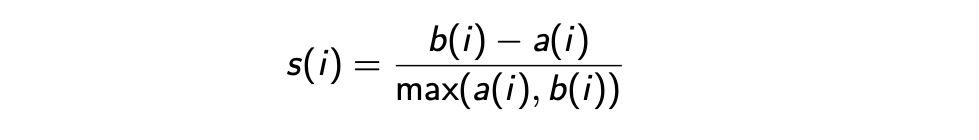

El valor del índice de Silhouette varía de -1 a 1. Si la puntuación es cercana 1, el grupo es denso y está bien separado que otros grupos. Un valor cercano a 0 representa grupos superpuestos con muestras muy cercanas al límite de decisión de los grupos vecinos. Una puntuación negativa [-1, 0] indica que las muestras pueden haber sido asignadas a grupos incorrectos.

In [ ]:
from sklearn.metrics import silhouette_score
clustering.fit_predict(X) #Ajustamos los datos de los cluster
# Calculamos el coeficiente de Silhouette
score = silhouette_score(X, clustering.labels_, metric='euclidean')
# Imprimimos el resultado
print('Silhouetter Score:',  score)

Silhouetter Score: 0.4980505049972867


Un resultado de 0.4980505049972867 nos indica que el agrupamiento fue hecho de una manera si bien no perfecta, es aceptable, ya que tampoco se encuentra cercano al 0, por lo que podemos decir que nuestro agrupamiento está correcto.

#4. Conclusión

Durante el desarrollo de éste ejercicio, se pusieron en práctica las técnicas de minería e datos que permitieran optimizar el análisis de la base de datos de interés. Así, se utilizó la ténica de agrupación por k-medias, con lo cual se permitió dividir los items en grupos menos masivos, con características similares, de tal manera que fuera más sencillo trabajar con ellos y que los elementos descriptivos de su análisis estadístico fueran más representativos.
Además, se ha aplicado un método de evaluación de ésta técnica con el fin de confirmar que el agrupamiento es aceptable.
Estos elementos resultan muy útiles para llegar a nuestro objetivo, puesto que permite elegir los criterios que necesitamos por posición, siendo que al momento de contratar a los jugadores nuevos, las vacantes se abren justamente por posición, y no de manera general.
Por ello, es importante implementar esta técnica en nuestra base de datos, de tal forma que, incluso si se decide utilizar una técnica adicional, los resultados de cualquier análisis que se haga utilizarían la discriminación por posición que se necesita para contratar a los jugadores.